In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, roc_auc_score, 
                            confusion_matrix, classification_report,
                            f1_score, precision_score, recall_score)
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('au_train.csv')

# Data Cleaning
# Remove leading/trailing whitespaces from string columns
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# Convert target to binary (0 for <=50K, 1 for >50K)
df['class'] = df['class'].map({'<=50K': 0, '>50K': 1})

# Define features and target
X = df.drop('class', axis=1)
y = df['class']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Define numerical and categorical features
numerical_features = ['age', 'fnlwgt', 'education-num', 
                     'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'education', 'marital-status', 
                       'occupation', 'relationship', 'race', 
                       'sex', 'native-country']

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',  # Handles class imbalance
        random_state=42,
        n_jobs=-1))])

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for AUROC

# Evaluate the model
print("Model Evaluation:")
print("-----------------")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))




Model Evaluation:
-----------------
Accuracy: 0.8560
AUROC: 0.9061
F1 Score: 0.6736
Precision: 0.7412
Recall: 0.6173

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      4945
           1       0.74      0.62      0.67      1568

    accuracy                           0.86      6513
   macro avg       0.81      0.77      0.79      6513
weighted avg       0.85      0.86      0.85      6513



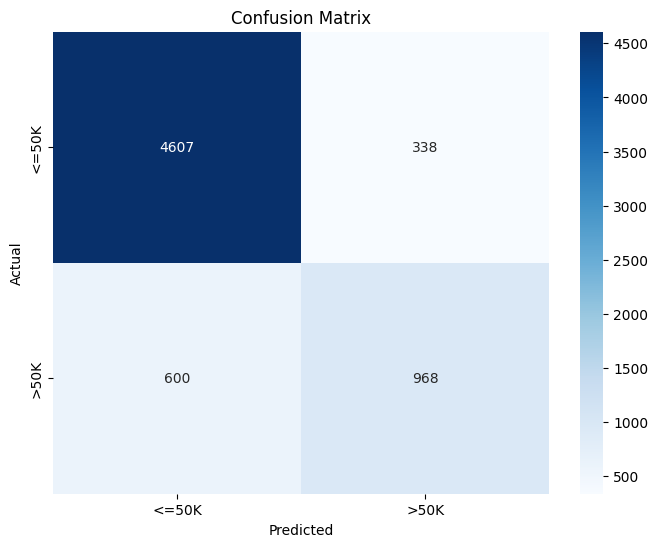

In [7]:
#Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['<=50K', '>50K'], 
            yticklabels=['<=50K', '>50K'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


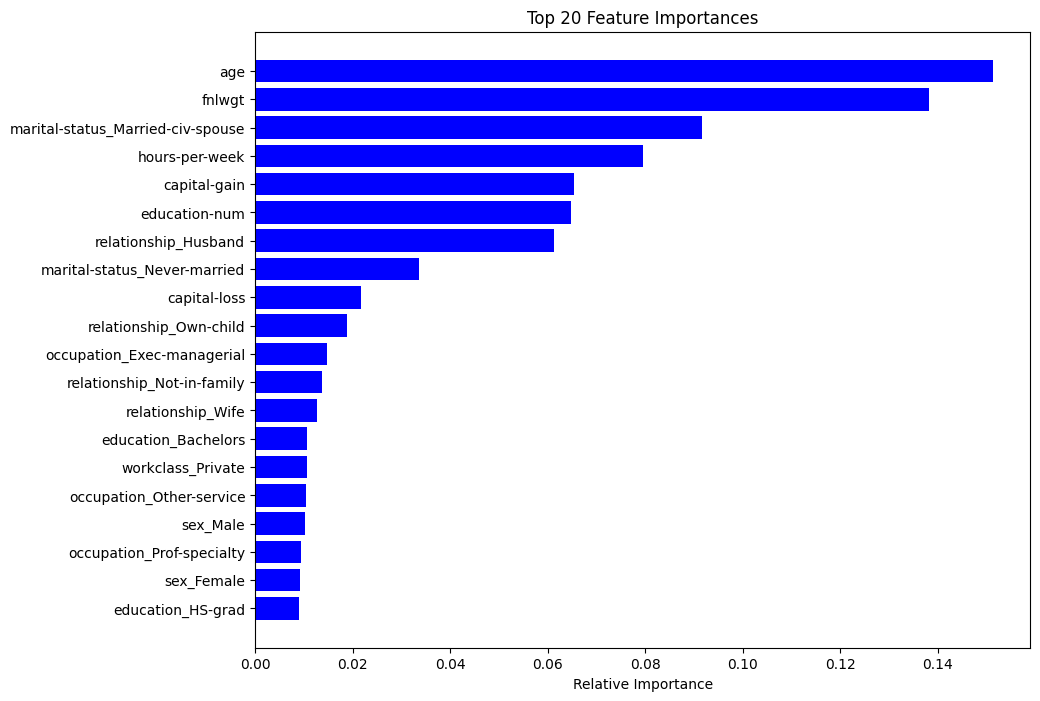

In [8]:
# Feature Importance (for tree-based models)
if hasattr(model.named_steps['classifier'], 'feature_importances_'):
    # Get feature names after one-hot encoding
    ohe_feature_names = model.named_steps['preprocessor'].named_transformers_['cat']\
        .named_steps['onehot'].get_feature_names_out(categorical_features)
    all_feature_names = numerical_features + list(ohe_feature_names)
    
    # Get feature importances
    importances = model.named_steps['classifier'].feature_importances_
    indices = np.argsort(importances)[-20:]  # Top 20 features

    # Plot
    plt.figure(figsize=(10, 8))
    plt.title('Top 20 Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [all_feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    

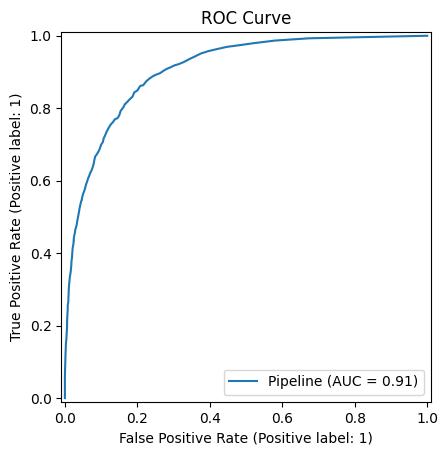

In [9]:
# ROC Curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title('ROC Curve')
plt.show()


In [10]:
import joblib
joblib.dump(model, 'income_predictor_model.pkl')



['income_predictor_model.pkl']